# **0. Importación de Librerías**

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
import joblib
import os

# **1. Carga y Validación inicial del dataset**

In [6]:
URL = "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"
df = pd.read_csv(URL)

print("Shape:", df.shape)
print("\nColumnas:", list(df.columns))
print("\nTipos de datos:")
print(df.dtypes)

print("\nNulos por columna:")
print(df.isna().sum())

print("\nDuplicados:", df.duplicated().sum())

# Vista rápida
display(df.head())
display(df.sample(5, random_state=42))

# Nombre de la variable objetivo
target = "Outcome"
print("\nTarget detectado:", target, "— valores:", df[target].unique(),
      "| distribución:\n", df[target].value_counts(normalize=True).round(3))

Shape: (768, 9)

Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Tipos de datos:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Nulos por columna:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Duplicados: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
668,6,98,58,33,190,34.0,0.430,43,0
324,2,112,75,32,0,35.7,0.148,21,0
624,2,108,64,0,0,30.8,0.158,21,0
690,8,107,80,0,0,24.6,0.856,34,0
473,7,136,90,0,0,29.9,0.210,50,0



Target detectado: Outcome — valores: [1 0] | distribución:
 Outcome
0    0.651
1    0.349
Name: proportion, dtype: float64


Como podemos observar, el `target` está desbalanceado (65% clase 0 y 35% clase 1), lo que más adelante nos obligará a considerar técnicas de balanceo.

# **2. EDA Descriptivio Inicial**

Descripción estadística:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


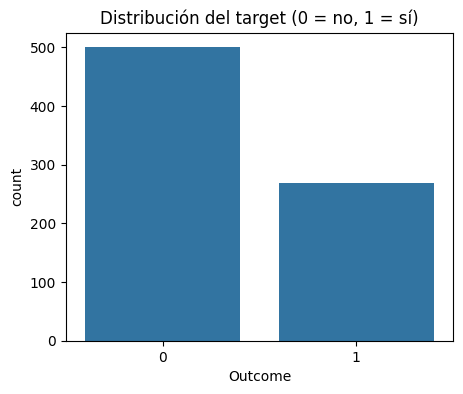

In [7]:
print("Descripción estadística:")
display(df.describe().T)

# Distribución del target
plt.figure(figsize=(5,4))
sns.countplot(x=df[target])
plt.title("Distribución del target (0 = no, 1 = sí)")
plt.show()


## *2.1. Detección de valores inválidos*

Valores 0 detectados por columna:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


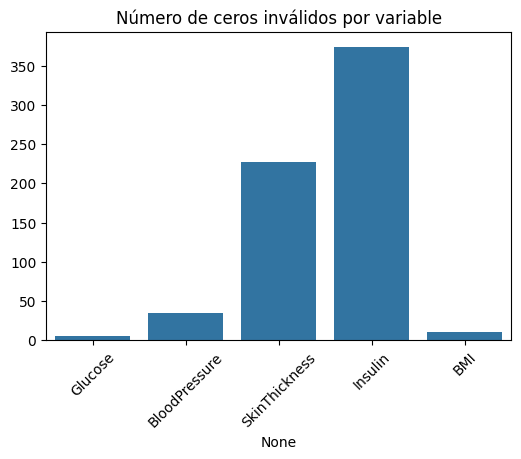

In [8]:
cols_with_invalid_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

invalid_counts = (df[cols_with_invalid_zero] == 0).sum()

print("Valores 0 detectados por columna:")
print(invalid_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=invalid_counts.index, y=invalid_counts.values)
plt.title("Número de ceros inválidos por variable")
plt.xticks(rotation=45)
plt.show()

Este dataset viene con un problema inherente: como podemos observar, las variables `SkinThickness`, así como `insulin` y `BloodPressure` presentan muchos casos con valor igual a 0. Esto nos indica, no que ese 0 sea real (ya que produciría la muerte del sujeto) si no que son valores no tomados. Si no son tratados con anterioridad, el árbol de decisión va a aprender ruido puro.

## *2.2. Imputación por mediana de valores fisiológicamente inválidos*

In [9]:
cols_nan_from_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

# Crea una copia y Convierte 0 en NaN en las columnas afectadas
df_clean = df.copy()  
df_clean[cols_nan_from_zero] = df_clean[cols_nan_from_zero].replace(0, np.nan)
df_clean[cols_nan_from_zero] = df_clean[cols_nan_from_zero].apply(
    lambda s: s.fillna(s.median())
)

# Verificación rápida
print("Ceros tras imputación:")
print((df_clean[cols_nan_from_zero] == 0).sum())

print("\nNaNs tras imputación:")
print(df_clean[cols_nan_from_zero].isna().sum())

display(df_clean[cols_nan_from_zero].describe().T)

Ceros tras imputación:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

NaNs tras imputación:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Glucose,768.0,121.656250,30.438286,44.0,99.75,117.0,140.25,199.0
BloodPressure,768.0,72.386719,12.096642,24.0,64.00,72.0,80.00,122.0
SkinThickness,768.0,29.108073,8.791221,7.0,25.00,29.0,32.00,99.0
Insulin,768.0,140.671875,86.383060,14.0,121.50,125.0,127.25,846.0
BMI,768.0,32.455208,6.875177,18.2,27.50,32.3,36.60,67.1


## *2.3. Detección de outliers y matriz de correlación*

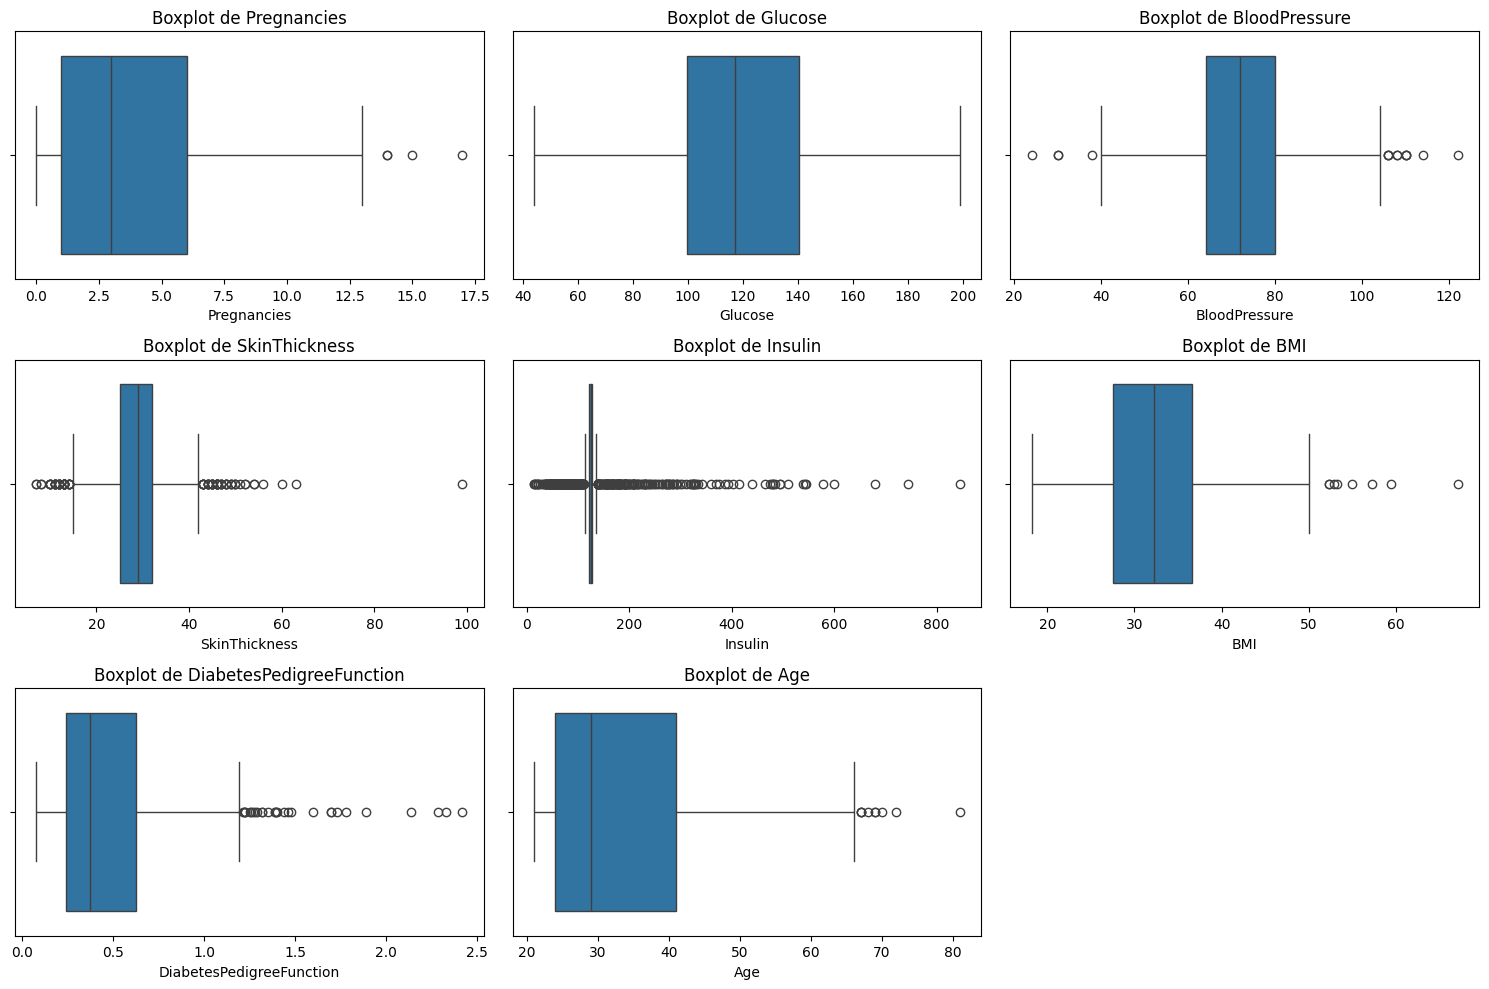

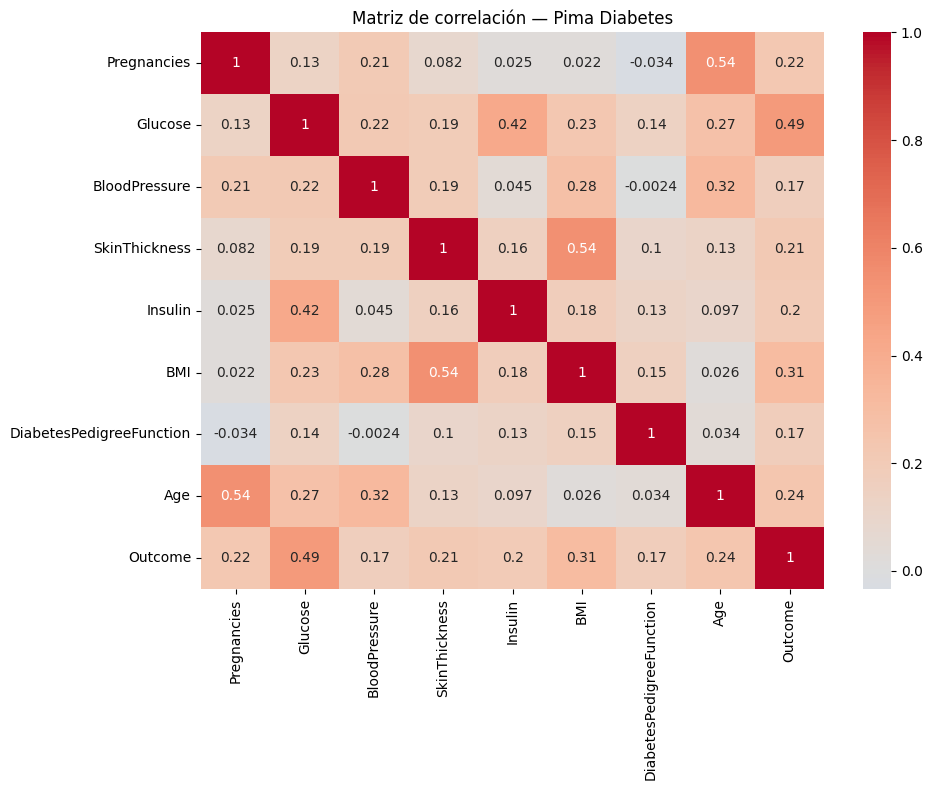


Correlación con Outcome (ordenada):
Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64


In [10]:
num_cols = df_clean.columns.drop("Outcome")

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df_clean[col], color="#1f77b4")
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# Matriz de correlación
corr = df_clean.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación — Pima Diabetes")
plt.tight_layout()
plt.show()

#Correlación con el target
corr_target = corr["Outcome"].sort_values(ascending=False)

print("\nCorrelación con Outcome (ordenada):")
print(corr_target)

# **3. Modelo de Árbol de Decisión Base**

Accuracy del modelo base: 0.6818

Matriz de confusión:


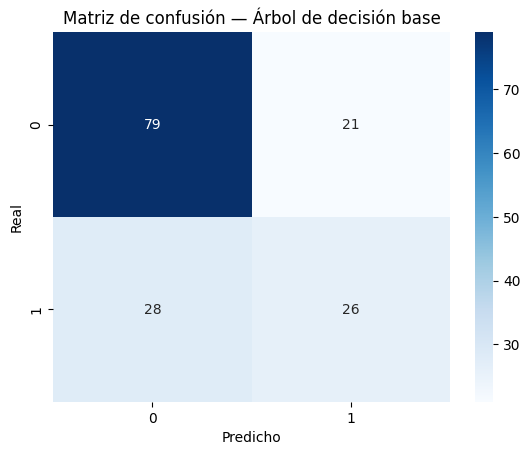


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       100
           1       0.55      0.48      0.51        54

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.67      0.68      0.68       154



In [11]:
# Separa features y target
X = df_clean.drop(columns=['Outcome'])
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenamiento del modelo base
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo base: {acc:.4f}")

print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión — Árbol de decisión base")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

El árbol base obtiene un 68% de accuracy, con mejor rendimiento en la clase 0 que en la 1 (F1≈0.51), lo que refleja el impacto del desbalance del dataset. En siguientes pasos será necesario optimizar el modelo y usar métricas más sensibles a la clase positiva.

## *3.0.1. Exportación del dataset para el siguiente ejercicio*

In [12]:
joblib.dump(X_train, "X_train.pkl")
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_train, "y_train.pkl")
joblib.dump(y_test, "y_test.pkl")

['y_test.pkl']

## *3.1. Comparación de funciones de pureza*

   Criterio  Accuracy  F1 (clase 1)
0      gini  0.681818      0.514851
1   entropy  0.675325      0.528302
2  log_loss  0.675325      0.528302


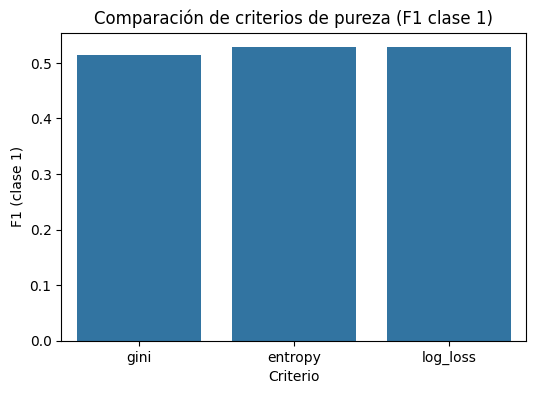

In [50]:
criterios = ["gini", "entropy", "log_loss"]
resultados = []

for crit in criterios:
    clf = DecisionTreeClassifier(criterion=crit, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    resultados.append([crit, acc, f1])

# Tabla resumen
df_resultados = pd.DataFrame(resultados, columns=["Criterio", "Accuracy", "F1 (clase 1)"])
print(df_resultados)

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(data=df_resultados, x="Criterio", y="F1 (clase 1)")
plt.title("Comparación de criterios de pureza (F1 clase 1)")
plt.show()

La comparación muestra diferencias muy pequeñas entre `gini`, `entropy` y `log_loss`; `entropy`/`log_loss` ofrecen un F1 ligeramente superior para la clase 1, por lo que son preferibles dado que nuestro objetivo es mejorar la detección de casos positivos.

# **4.Optimización del árbol con Grid Search**

Mejores hiperparámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}

Mejor score de validación (F1): 0.6283302701991614

Métricas del modelo optimizado:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



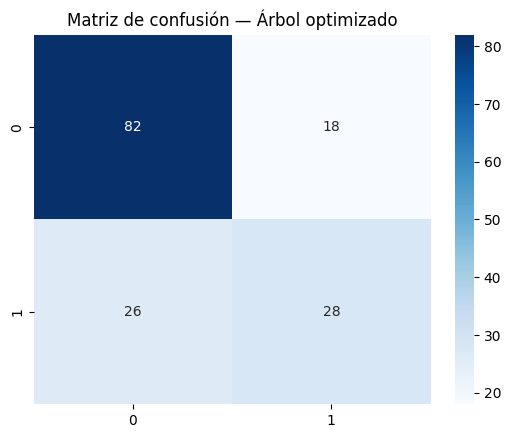

In [51]:
# Define el árbol base con el mejor criterio encontrado
dt = DecisionTreeClassifier(criterion="entropy", random_state=42)

# Hiperparámetros a explorar
param_grid = {
    "max_depth": [None, 3, 5, 7, 9, 12],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, "sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="f1",     
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

print("\nMejor score de validación (F1):", grid.best_score_)

# Entrena el modelo final
best_dt = grid.best_estimator_

y_pred_opt = best_dt.predict(X_test)

print("\nMétricas del modelo optimizado:")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm_opt, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de confusión — Árbol optimizado")
plt.show()

El Grid Search permitió ajustar el árbol para mejorar la detección de la clase positiva, aumentando el F1 de la clase 1 y elevando la capacidad generalizadora del modelo. El árbol resultante ofrece un mejor equilibrio entre precisión y recall que el modelo base.

## *4.2. Evaluación adicional del modelo*

ROC-AUC: 0.7996


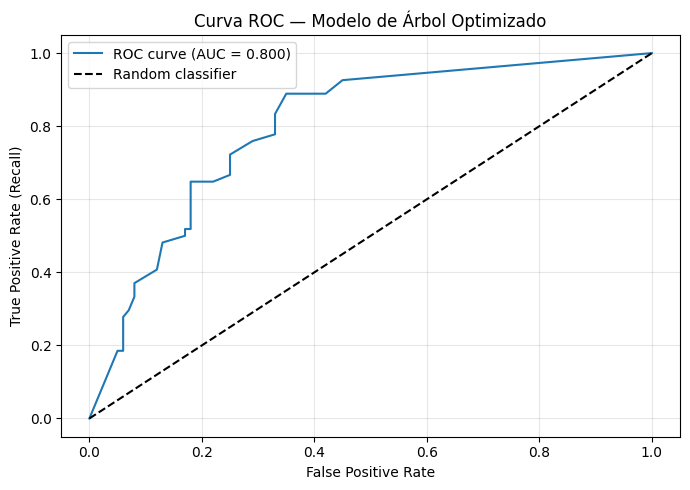

In [52]:
# Probabilidades para la clase positiva
y_proba = best_dt.predict_proba(X_test)[:, 1]

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# Pintado de la Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC — Modelo de Árbol Optimizado")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

El AUC en torno a 0.80 indica un modelo con buena capacidad discriminativa.

# **5. Guardado del modelo**

In [53]:
# Carpeta y ruta donde se guarda el modelo
save_path = "models"
os.makedirs(save_path, exist_ok=True)
model_filename = os.path.join(save_path, "decision_tree_diabetes.pkl")

# Guarda el modelo
joblib.dump(best_dt, model_filename)

print(f"Modelo guardado correctamente en: {model_filename}")

Modelo guardado correctamente en: models/decision_tree_diabetes.pkl


# **6. Conclusiones Finales**

**El análisis partió de un dataset con múltiples valores fisiológicamente inválidos**, que fueron imputados correctamente para evitar que el modelo aprendiera ruido. Tras un EDA completo, se seleccionaron todas las variables dado que ninguna mostraba correlaciones problemáticas o redundancias severas. **El árbol de decisión base ofreció un rendimiento limitado, especialmente en la clase minoritaria** (diabéticos). Explorando distintas funciones de pureza y **realizando una optimización mediante Grid Search, el modelo final mejoró tanto en precisión como en equilibrio entre clases**, alcanzando un AUC cercano a 0.80. Finalmente, el modelo fue almacenado para futuros despliegues o evaluaciones.